In [1]:
class Tree :
    def __init__(self,data,target,depth):
            if depth==0:
                self.leaf = True
                self.prediction = self.avg(target)
            elif len(set(target)) ==1:
                self.leaf = True
                self.prediction = target[0]
            else:
                self.leaf = False
                self.attr , self.split , self.L , self.R = self.generate(data,target,depth)

    def generate(self,data,target,depth):
        from sklearn.utils import resample
        from math import ceil
        import random
        opt = float('inf')
        p=len(data[0])
        random_features = resample(range(p),n_samples=ceil(p/3),replace=False)
        for j in random_features: #for each feature j
            all_cuts = set( sample[j] for sample in data )
            
            while len(all_cuts)== 1 : #all samples have the same value for this feature -> we cannot split the data in two groups
                f=list(range(p))
                f.remove(j)
                j=random.choice(f)
                all_cuts = set( sample[j] for sample in data )
                
            all_cuts.remove(max(all_cuts))
            for cut in all_cuts:
                xl=[];xr=[];yl=[];yr=[];
                for i in range(len(data)):
                    if data[i][j]<=cut:
                        xl.append(data[i])
                        yl.append(target[i])
                    else:
                        xr.append(data[i])
                        yr.append(target[i])
                        
                tmp = self.rss(yl) + self.rss(yr)
                if tmp < opt:
                    opt , attr , split, XL, XR , YL , YR = tmp , j , cut , xl , xr , yl , yr
        return attr , split , Tree(XL,YL,depth-1) , Tree(XR,YR,depth-1)

    def avg(self,target):
        if len(target) == 0:
            return 0
        return sum(target)/len(target)

    def rss(self,target):
        if len(target) == 0:    
            return 0
        mean = self.avg(target)
        return sum([ pow( y-mean , 2.0 ) for y in target ])





In [2]:
def print_the_tree(node):
    if node.leaf :
        print(node.prediction)
    else:
        print("attr and split",node.attr,node.split)
        print_the_tree(node.L)
        print_the_tree(node.R)

In [3]:
class RandomForest :

    def __init__(self,data,target,BTS_num=100,depth=3):
        self.forest = self.generate_random_forest(data,target,depth,BTS_num)
        
    def generate_BTSs(self,n,data,target):
        from sklearn.utils import resample
        import numpy as np
        import pandas as pd
        new = np.c_[np.array(data),np.array(target)]
        mydata = pd.DataFrame(data=new,columns = range(len(new[0])))
        BTSs=[]
        for i in range(n):
            samples = mydata.sample(mydata.shape[0], replace=True)
            samples = samples.drop_duplicates()
            d = samples.iloc[:,0:len(new[0])-1].to_numpy()
            t = samples.iloc[:,len(new[0])-1].to_numpy()
            BTSs.append((d,t))
        return BTSs

    def generate_random_forest(self,data,target,depth,BTS_num):
        BTSs= self.generate_BTSs(BTS_num,data,target)
        trees=[]
        for d,t in BTSs:
            trees.append(Tree(d,t,depth))
        return trees
    def predict_single_test_tree(self,test,node):
        if node.leaf == True:
            return node.prediction
        if test[node.attr] <= node.split :
            return self.predict_single_test_tree(test,node.L)
        else :
            return self.predict_single_test_tree(test,node.R)
            
    def predict(self,data_test):
        answers = []
        for test in data_test :
            summ=0
            for tree in self.forest :
                summ+= self.predict_single_test_tree(test,tree)
            answers.append(summ/len(self.forest))
        return answers
    def MSE(self,data,target):
        import numpy as np
        y_hat = self.predict(data)
        return ((y_hat - target)**2).mean()

In [4]:
from sklearn.datasets import load_boston
boston = load_boston()
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(boston.data,boston.target,test_size=0.5,random_state=103)
randomForest = RandomForest(X_train,y_train,100,3)

In [5]:
print(randomForest.MSE(X_test,y_test))

16.160637879388453


In [6]:
print(randomForest.MSE(X_train,y_train))

11.654255427817704


In [7]:
B = [1,2,3,4,5,10 ,20, 40, 60, 80, 100]
MSE_test = []
MSE_train = []
for b in B :
    randomForest = RandomForest(X_train,y_train,b,3)
    MSE_test.append(randomForest.MSE(X_test,y_test))
    MSE_train.append(randomForest.MSE(X_train,y_train))
       

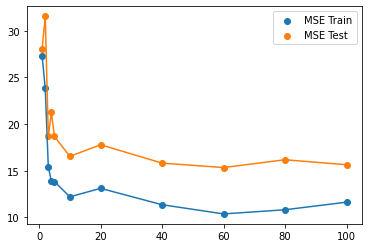

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
a=plt.scatter(B,MSE_train)
plt.plot(B,MSE_train)
b=plt.scatter(B,MSE_test)
plt.plot(B,MSE_test)
plt.legend((a,b),('MSE Train', 'MSE Test'))
plt.savefig('B.png')
plt.show()    

In [9]:
H = range(2,15)
MSE_test2 = []
MSE_train2 = []
for h in H :
    randomForest = RandomForest(X_train,y_train,10,h)
    MSE_test2.append(randomForest.MSE(X_test,y_test))
    MSE_train2.append(randomForest.MSE(X_train,y_train))

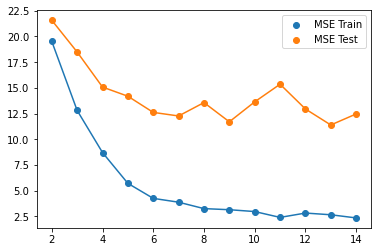

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
a=plt.scatter(H,MSE_train2)
plt.plot(H,MSE_train2)
b=plt.scatter(H,MSE_test2)
plt.plot(H,MSE_test2)
plt.legend((a,b),('MSE Train', 'MSE Test'))
plt.savefig('H.png')
plt.show()  